In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by agency

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [3]:
table_df = df.copy()
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df

,agency,observed_boardings,model_boardings,diff,perc_diff
2,King County Metro,"253,313.62","369,224.93","115,911.31",45.76%
5,Sound Transit,"113,374.00","157,833.27","44,459.27",39.21%
0,Community Transit,"25,962.00","28,240.08","2,278.08",8.77%
4,Pierce Transit,"21,185.00","23,192.74","2,007.74",9.48%
6,Washington Ferries,"9,278.21","5,729.10","-3,549.11",-38.25%
3,Kitsap Transit,"7,789.00","28,232.30","20,443.30",262.46%
1,Everett Transit,"4,201.00","3,220.71",-980.29,-23.33%


In [4]:
# fig = px.bar(plot_df.sort_values('source'), x="agency", y="count",
#              color="source", barmode="group",
#              title="transit boardings by agency")
# fig.update_layout(height=400, width=700, font=dict(size=11),
#                   yaxis_tickformat = '.2f')
# fig.show()

### boarding by key route

In [5]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,W,759.00,939.91,180.91,23.83%
1,S,338.00,950.32,612.32,181.16%
2,Kingston - EdmondsE,"1,500.13",140.30,"-1,359.83",-90.65%
3,Bainbridge Island -,"5,513.69","3,363.04","-2,150.65",-39.01%
4,WSF Bremerton - Seat,"1,188.97",163.17,"-1,025.80",-86.28%
5,Southworth - Fauntle,142.56,233.12,90.56,63.53%
6,Vashon Island - Faun,560.04,"1,536.23",976.19,174.31%
7,Southworth - Vashon,107.76,113.80,6.04,5.60%
8,Point Defiance - Tah,265.05,179.43,-85.63,-32.31%


r^2 : 0.8337552482791967


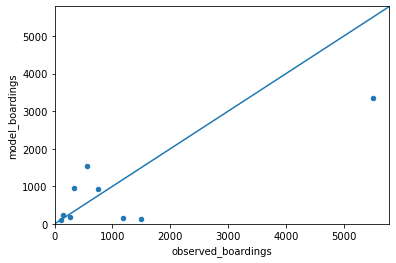

In [6]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

##### bikes on ferry

In [7]:
df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
df['route_code'] = df['route_code'].astype('int')
df[['route_code','description', '@bvol']]

,route_code,description,@bvol
4,4203,Annapolis Foot Ferry,818.50
2,4200,Bremerton-Seattle Fa,489.80
3,4201,Bremerton-Port Orcha,446.70
0,1973,E,336.10
1,1975,N,191.10
11,5007,Point Defiance - Tah,77.00
7,5002,Bainbridge Island -,60.80
10,5005,Vashon Island - Faun,58.40
9,5004,Fauntleroy - Southwo,29.40
6,5001,Kingston - EdmondsE,17.00


In [8]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Link Red Line,"79,522.00","78,025.96","-1,496.04",-1.88%
1,Sounder South,"6,038.00","12,158.18","6,120.18",101.36%
2,Sounder North,316.00,18.02,-297.98,-94.30%


r^2 : 0.9967772745786729


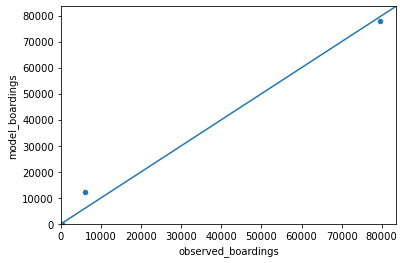

In [9]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [10]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
6,E Line RapidRide,"11,426.00","20,884.90","9,458.90",82.78%
4,C Line RapidRide,"7,250.00","14,119.07","6,869.07",94.75%
1,KC Metro 40,"7,208.00","12,793.09","5,585.09",77.48%
0,KC Metro 7,"9,954.00","11,162.80","1,208.80",12.14%
5,D Line RapidRide,"9,044.00","9,941.88",897.88,9.93%
10,Sound Transit 550,"3,351.00","9,634.43","6,283.43",187.51%
2,A Line RapidRide,"8,412.00","8,105.15",-306.85,-3.65%
7,F Line RapidRide,"4,748.00","5,805.74","1,057.74",22.28%
3,B Line RapidRide,"4,177.00","4,380.08",203.08,4.86%
9,First Hill Streetcar,"3,900.45","1,369.74","-2,530.71",-64.88%


r^2 : 0.8072386745657423


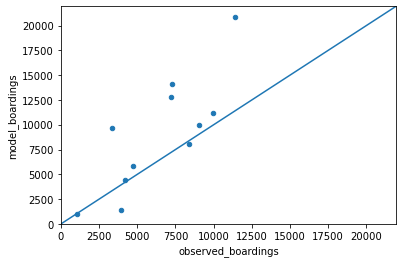

In [11]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### boarding on lines by agency

r^2 Community Transit: 0.9135571262720011
r^2 Everett Transit: 0.9488895248377024


r^2 King County Metro: 0.9003651679287995
r^2 Kitsap Transit: 0.6102722229242511
r^2 Pierce Transit: 0.7831322219145825


r^2 Sound Transit: 0.9885842382425686
r^2 Washington Ferries: 0.8649304870331177


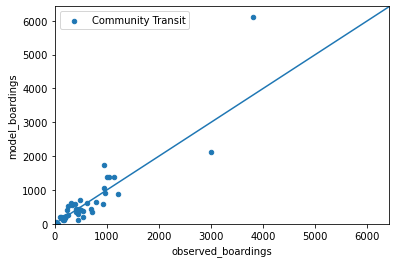

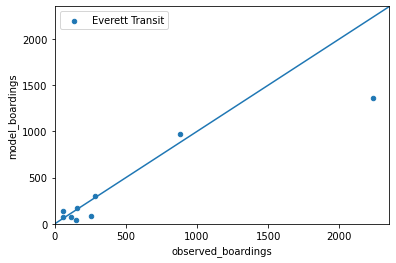

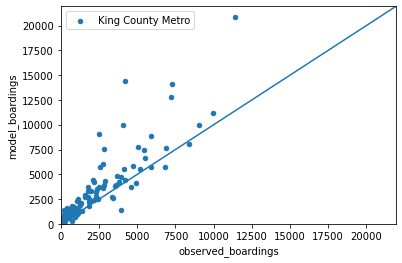

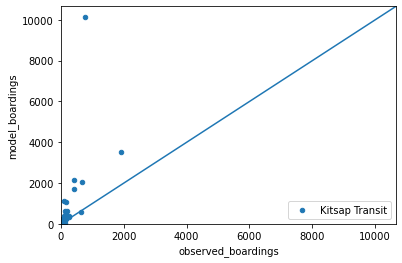

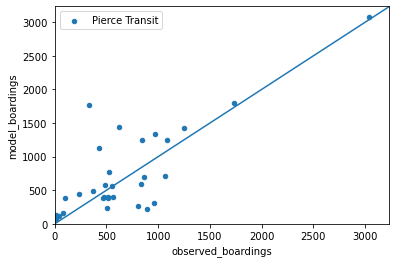

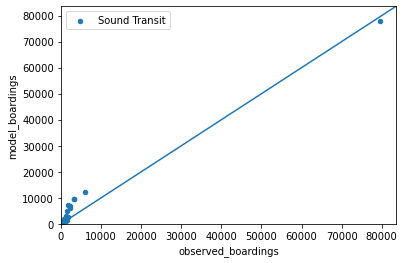

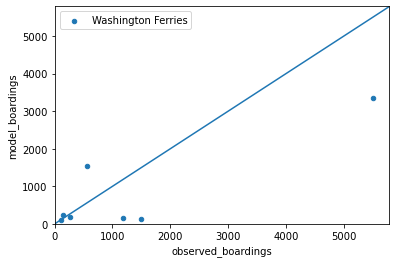

In [12]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [13]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"6,134.00","4,491.70","-1,642.30",-26.77%
Westlake,"8,845.00","9,101.61",256.61,2.90%
University St,"4,324.00","6,093.94","1,769.94",40.93%
Pioneer Square,"2,400.00","5,069.74","2,669.74",111.24%
Int'l District,"4,399.00","1,759.27","-2,639.73",-60.01%
Capitol Hill,"7,667.00","6,368.16","-1,298.84",-16.94%
Stadium,"1,731.00",520.70,"-1,210.30",-69.92%
SODO,"1,669.00","3,239.06","1,570.06",94.07%
Beacon Hill,"2,147.00","1,025.06","-1,121.94",-52.26%


In [14]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/University St'
df_combined.loc[['University St'],'station_group'] = 'Westlake/University St'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/University St',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"6,134.00","4,491.70","-1,642.30",-26.77%
Capitol Hill,"7,667.00","6,368.16","-1,298.84",-16.94%
Westlake/University St,"13,169.00","15,195.55","2,026.55",15.39%
Pioneer Square/Int'l District,"6,799.00","6,829.01",30.01,0.44%
Stadium/SODO,"3,400.00","3,759.76",359.76,10.58%
Beacon Hill/Mount Baker,"4,008.00","2,248.90","-1,759.10",-43.89%
Columbia City,"1,630.00","1,178.56",-451.44,-27.70%
Othello/Rainier Beach,"3,525.00","2,619.08",-905.92,-25.70%
Tukwila Int'l Blvd,"2,298.00","1,863.39",-434.61,-18.91%


### light rail stop transfers

In [15]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.92,-99.00,99.92,-100.92%
Westlake,0.16,0.36,-0.20,-55.05%
University St,0.27,0.20,0.07,33.13%
Pioneer Square,0.43,0.16,0.27,171.29%
Int'l District,0.65,0.45,0.20,43.39%
Capitol Hill,0.07,-99.00,99.07,-100.07%
Stadium,0.26,0.12,0.14,119.87%
SODO,0.56,0.31,0.25,78.64%
Beacon Hill,0.36,0.35,0.01,1.80%
